In [33]:
import numpy as np
import random
import cv2 as cv
from skimage import filters
from skimage.feature import corner_peaks
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 500

In [34]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [35]:
def CornerResponse(img, window, sigma, alpha):
    Ix = filters.sobel_v(img)
    Iy = filters.sobel_h(img)
    ker = cv.getGaussianKernel(window, sigma = sigma)
    Ixx = cv.filter2D(Ix ** 2, -1, ker)
    Ixy = cv.filter2D(Ix * Iy, -1, ker)
    Iyy = cv.filter2D(Iy ** 2, -1, ker)
    response = (Ixx * Iyy - Ixy ** 2) - alpha * (Ixx + Iyy) ** 2
    return response

def HarrisCornerDetector(img, window = 5, sigma = 2, alpha = 0.05, threshold = 0.04):
    response = CornerResponse(img, window, sigma, alpha)
    return corner_peaks(response, threshold_rel = threshold)

In [36]:
def NormalizedCorrelation(img1, x1, y1, img2, x2, y2, r):
    batch1 = img1[x1 - r : x1 + r + 1, y1 - r : y1 + r + 1]
    mu1 = np.mean(batch1)
    sigma1 = np.std(batch1)
    batch2 = img2[x2 - r : x2 + r + 1, y2 - r : y2 + r + 1]
    mu2 = np.mean(batch2)
    sigma2 = np.std(batch2)
    n = (2 * r - 1) ** 2
    corr = np.sum(((batch1 - mu1) / sigma1) * ((batch2 - mu2) / sigma2)) / n
    return corr

def FindMatchingPairs(img1, corners1, img2, corners2, r = 7, threshold = 0.999):
    h, w = img1.shape
    m, _ = corners1.shape
    n, _ = corners2.shape
    p1 = []
    p2 = []
    for i in range(m):
        if r <= corners1[i, 0] <= h - r - 1 and r <= corners1[i, 1] <= w - r - 1:
            for j in range(n):
                if r <= corners2[j, 0] <= h - r - 1 and r <= corners2[j, 1] <= w - r - 1:
                    if NormalizedCorrelation(img1, corners1[i, 0], corners1[i, 1], img2, corners2[j, 0], corners2[j, 1], r) > threshold:
                        p1.append(corners1[i])
                        p2.append(corners2[j])
    p1 = np.array(p1)
    p2 = np.array(p2)
    return p1, p2

In [37]:
def ComputeHomographyMatrix(p1, p2):
    m = len(p1)
    A = np.zeros((2 * m, 9))
    for i in range(m):
        A[2 * i, :] = [p1[i][0], p1[i][1], 1, 0, 0, 0, -p2[i][0] * p1[i][0], -p2[i][0] * p1[i][1], -p2[i][0]]
        A[2 * i + 1, :] = [0, 0, 0, p1[i][0], p1[i][1], 1, -p2[i][1] * p1[i][0], -p2[i][1] * p1[i][1], -p2[i][1]]
    _, _, V = np.linalg.svd(A)
    H = np.reshape(V[-1, :], (3, 3))
    return H

In [38]:
def RANSAC(p1, p2, iteration = 1000, threshold = 1):
    n = len(p1)
    population = range(n)
    max_inliers = 0
    satisfied = []
    for _ in range(iteration):
        inliers = 0
        sample = random.sample(population, 4)
        H = ComputeHomographyMatrix(p1[sample], p2[sample])
        for i in range(n):
            [x1, y1] = p1[i]
            [x2, y2, z2] = np.dot(H, np.array([x1, y1, 1]).T)
            [x2, y2] = [x2, y2] / z2
            if np.linalg.norm([x2, y2] - p2[i]) < threshold:
                inliers += 1
                sample.append(i)
        if inliers > max_inliers:
            max_inliers = inliers
            satisfied = sample
    H = ComputeHomographyMatrix(p1[satisfied], p2[satisfied])
    return H

In [39]:
def BilinearInterpolation(img, x, y):
    i = int(np.floor(x))
    j = int(np.floor(y))
    a = (x - i) * img[i + 1, j] + (i + 1 - x) * img[i, j]
    b = (x - i) * img[i + 1, j + 1] + (i + 1 - x) * img[i, j + 1]
    c = (y - j) * b + (j + 1 - y) * a
    return c

In [40]:
def ImageWrapping(background, img, H, offset):
    h, w, _ = img.shape
    Hinv = np.linalg.inv(H)
    corners = np.array([[0, 0, 1], [h - 1, 0, 1], [0, w - 1, 1], [h - 1, w - 1, 1]]).T
    corners_wrapped = np.dot(H, corners)
    corners_wrapped /= corners_wrapped[2, :]
    i_min = int(np.floor(np.min(corners_wrapped[0, :])))
    i_max = int(np.ceil(np.max(corners_wrapped[0, :])))
    j_min = int(np.floor(np.min(corners_wrapped[1, :])))
    j_max = int(np.ceil(np.max(corners_wrapped[1, :])))
    for i in range(i_min, i_max):
        for j in range(j_min, j_max):
            [x, y, z] = np.dot(Hinv, np.array([i, j, 1]))
            [x, y] = [x, y] / z
            if 0 <= x <= h - 2 and 0 <= y <= w - 2:
                background[i + offset[0], j + offset[1]] = BilinearInterpolation(img, x, y)
    

In [41]:
img0 = cv.imread('Rainier0.png')
img1 = cv.imread('Rainier1.png')
img2 = cv.imread('Rainier2.png')
img3 = cv.imread('Rainier3.png')
img4 = cv.imread('Rainier4.png')
img5 = cv.imread('Rainier5.png')

img0_gray = rgb2gray(img0)
img1_gray = rgb2gray(img1)
img2_gray = rgb2gray(img2)
img3_gray = rgb2gray(img3)
img4_gray = rgb2gray(img4)
img5_gray = rgb2gray(img5)

In [42]:
corners0 = HarrisCornerDetector(img0_gray)
corners1 = HarrisCornerDetector(img1_gray)
corners2 = HarrisCornerDetector(img2_gray)
corners3 = HarrisCornerDetector(img3_gray)
corners4 = HarrisCornerDetector(img4_gray)
corners5 = HarrisCornerDetector(img5_gray)

p1, p2 = FindMatchingPairs(img0_gray, corners0, img1_gray, corners1)
p3, p4 = FindMatchingPairs(img1_gray, corners1, img2_gray, corners2)
p5, p6 = FindMatchingPairs(img0_gray, corners0, img3_gray, corners3)
p7, p8 = FindMatchingPairs(img1_gray, corners1, img4_gray, corners4)
p9, p10 = FindMatchingPairs(img2_gray, corners2, img5_gray, corners5)

In [43]:
H1 = RANSAC(p1, p2)
H2 = RANSAC(p4, p3)
H3 = RANSAC(p6, p5)
H4 = RANSAC(p8, p7)
H5 = RANSAC(p10, p9)

C:\Users\huunh\AppData\Local\Temp\ipykernel_15196\3284451828.py:13: RuntimeWarning: divide by zero encountered in true_divide
  [x2, y2] = [x2, y2] / z2


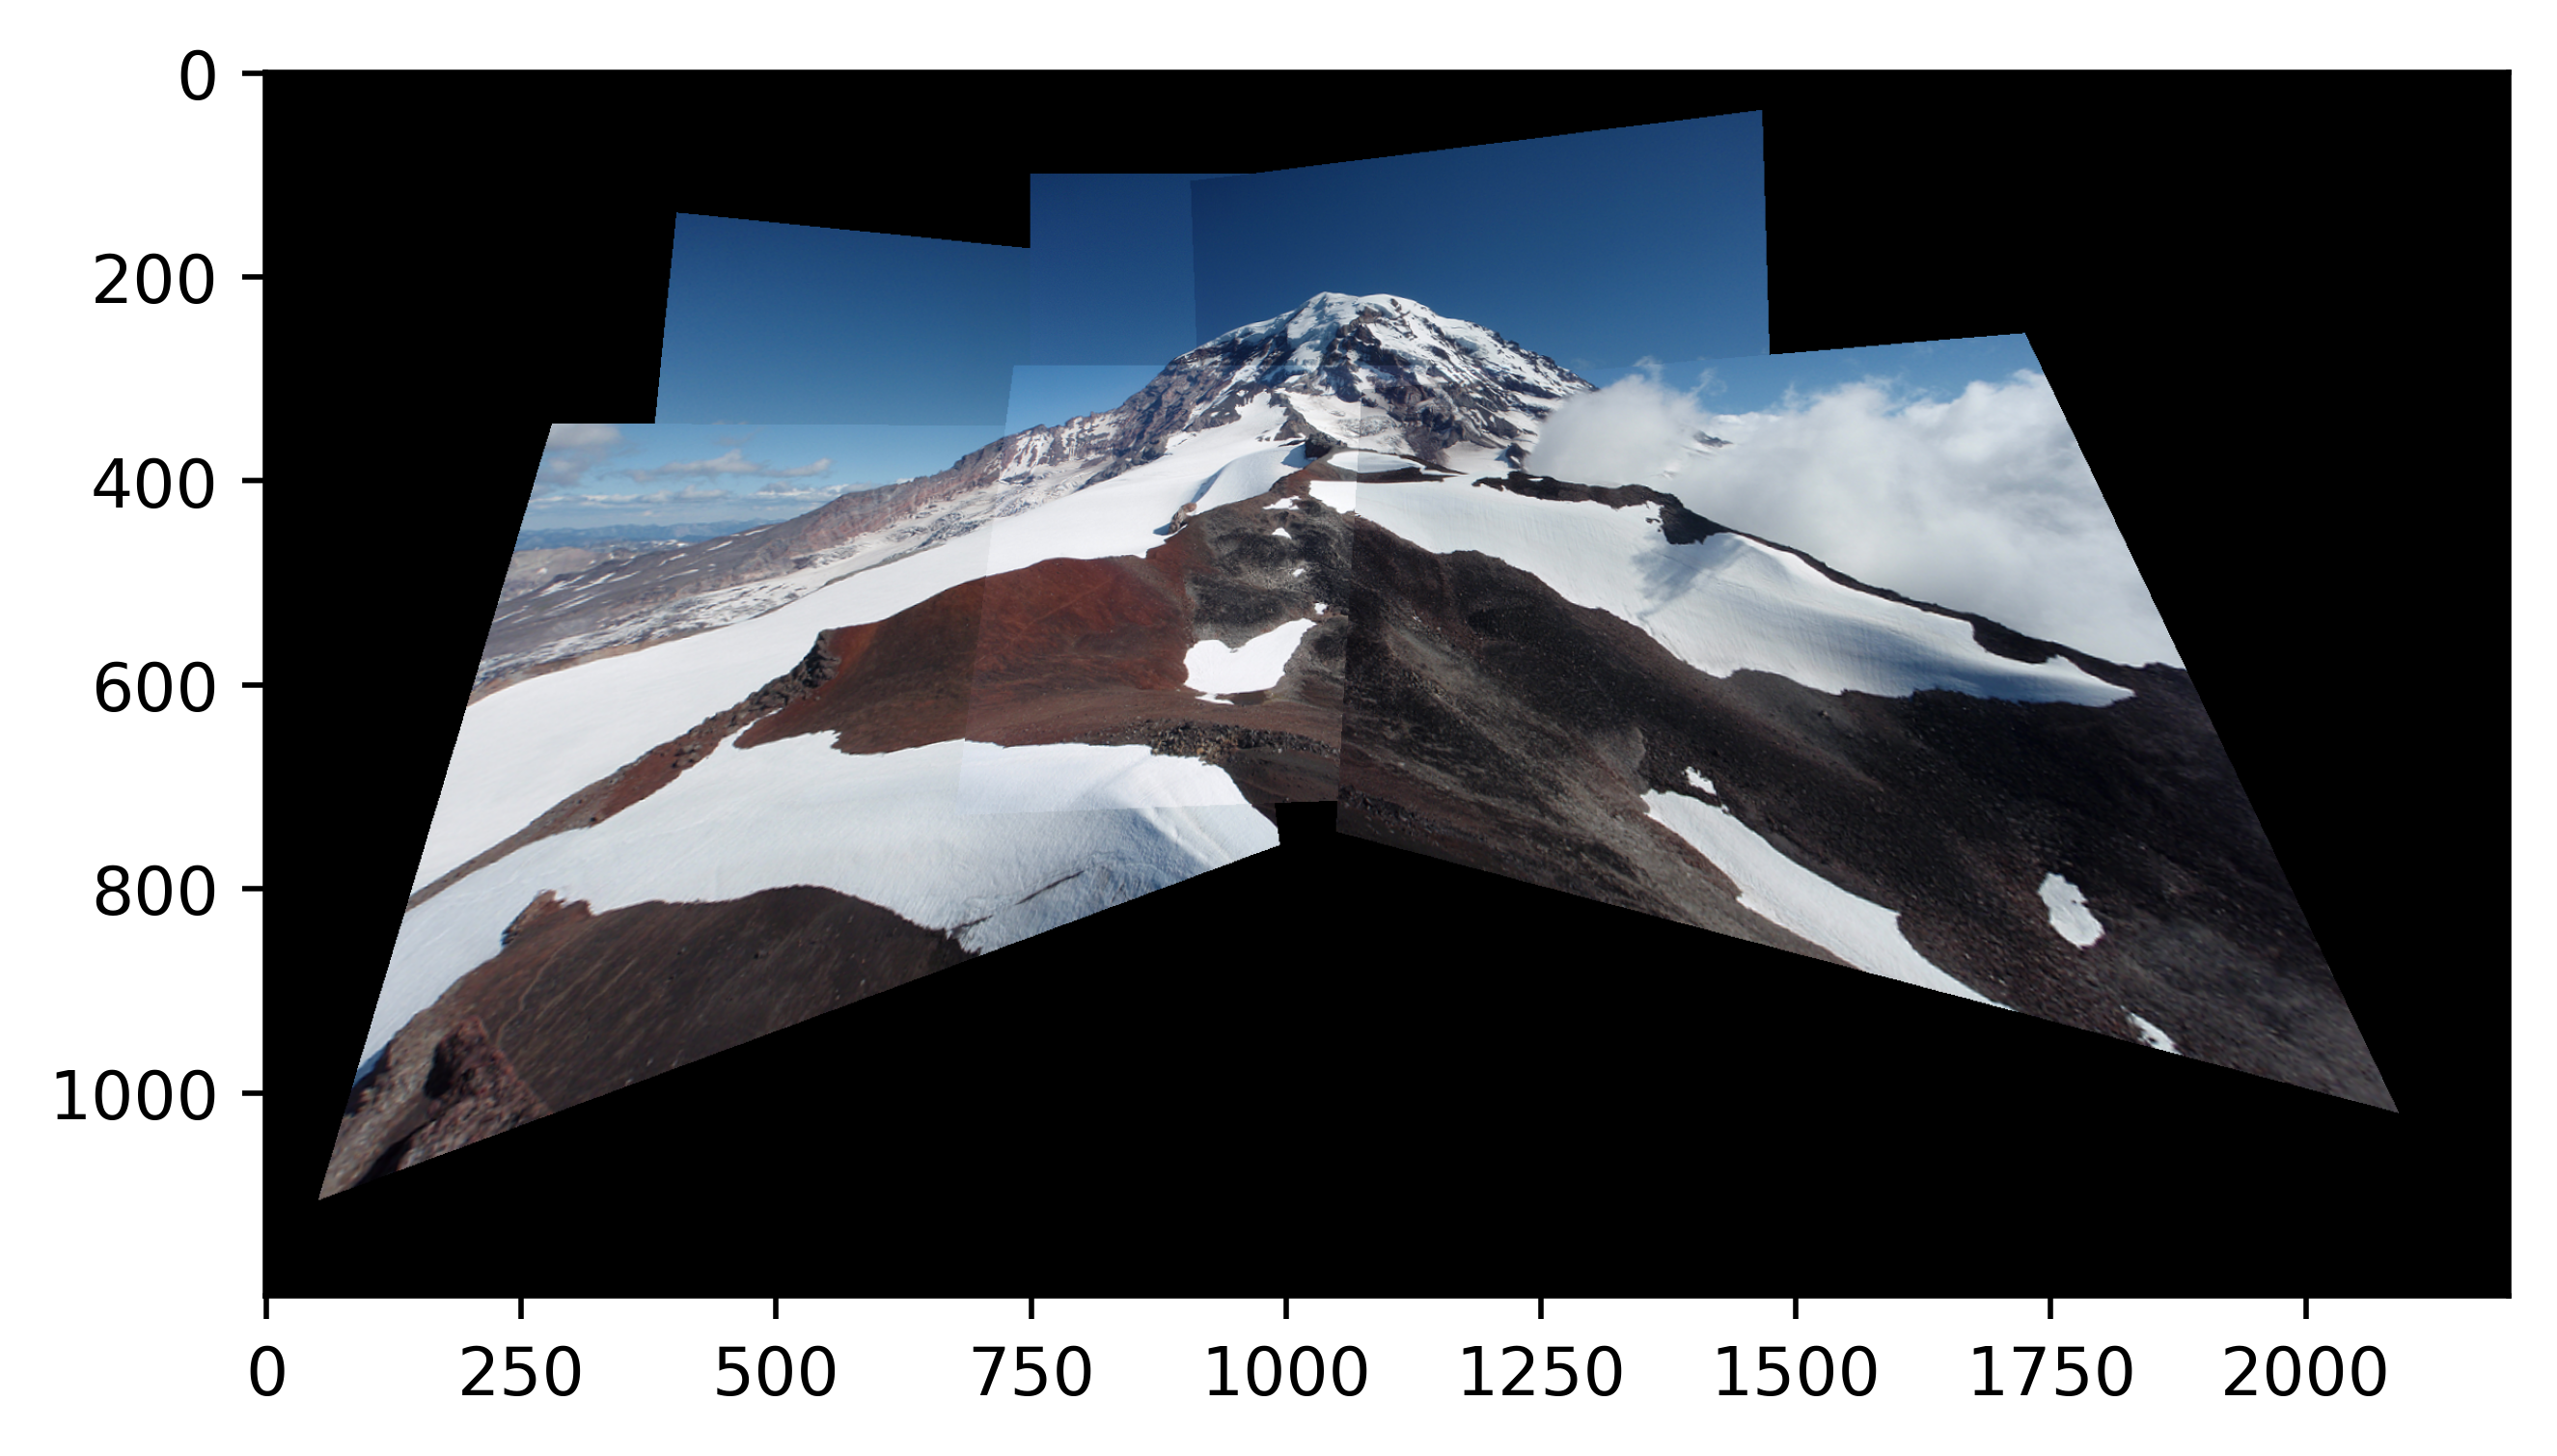

In [44]:
output_shape_h, output_shape_w = 1200, 2200
output_space = np.zeros((output_shape_h, output_shape_w, 3), dtype = 'uint8')

ImageWrapping(output_space, img0, H1, (100, 750))
ImageWrapping(output_space, img1, np.eye(3), (100, 750))
ImageWrapping(output_space, img2, H2, (100, 750))
ImageWrapping(output_space, img3, np.dot(H1, H3), (100, 750))
ImageWrapping(output_space, img4, H4, (100, 750))
ImageWrapping(output_space, img5, np.dot(H2, H5), (100, 750))

plt.imshow(cv.cvtColor(output_space, cv.COLOR_BGR2RGB))